# ⚽ Ball Tracking — Cinemática del Balón

Pipeline completo para detectar y trackear el balón de fútbol frame a frame, 
calculando posición, velocidad y dirección. Exporta `ball_tracking_data.csv`.

**Diferencias respecto al notebook de jugadores:**
- Usa un **modelo especializado** en balones de fútbol (mejor que COCO `sports ball`).
- Aplica un **filtro de Kalman** para interpolar frames donde el balón no se detecta.
- Calcula **velocidad**, **aceleración** y **ángulo de movimiento** del balón.
- Umbral de confianza más bajo (`0.25`) + NMS estricto para evitar falsos positivos.

## 1 · Instalación de dependencias

In [1]:
!pip install ultralytics supervision opencv-python-headless pandas matplotlib seaborn filterpy -q

## 2 · Imports

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import deque
from ultralytics import YOLO
import supervision as sv
from filterpy.kalman import KalmanFilter

## 3 · Configuración

> **Ajusta las rutas y parámetros antes de ejecutar.**

In [ ]:
# ─── Rutas ────────────────────────────────────────────────────────────────────
INPUT_VIDEO_PATH  = r'C:\ruta\a\proyecto\field_vision_sant\videos\input\0bfacc_0.mp4'
OUTPUT_VIDEO_PATH = r'C:\ruta\a\proyecto\field_vision_sant\videos\output\ball_output_0bfacc_0.mp4'
OUTPUT_CSV_PATH   = 'ball_tracking_data.csv'

# ─── Modelo ───────────────────────────────────────────────────────────────────
# Opción A (recomendada): modelo especializado en balones de fútbol.
#   Descarga automática desde Roboflow Universe la primera vez:
#   MODEL_NAME = 'keremberke/football-ball-detection:1'   # requiere rf.load()
#
# Opción B (por defecto): yolov8n.pt (COCO general, clase 32 = sports ball).
#   Funciona sin dependencias extra; puede tener más falsos negativos.
MODEL_NAME    = 'yolov8n.pt'
BALL_CLASS_ID = 32            # COCO: sports ball = 32

# ─── Detección ────────────────────────────────────────────────────────────────
CONF_THRESHOLD = 0.25   # más bajo que jugadores — el balón es pequeño
IOU_THRESHOLD  = 0.3    # NMS estricto: descarta duplicados agresivamente
MAX_BALL_SIZE  = 80     # píxeles — ignora detecciones más grandes (falso positivo)
MIN_BALL_SIZE  = 5      # píxeles — ignora detecciones demasiado pequeñas

# ─── Kalman / interpolación ───────────────────────────────────────────────────
MAX_MISSING_FRAMES = 10  # tras N frames sin balón, reinicia el filtro

# ─── Calibración píxel → metro ────────────────────────────────────────────────
# Para un análisis real usa la homografía del notebook de jugadores.
# Aquí usamos conversión lineal como fallback.
PIXELS_PER_METER = 10.0  # ← AJUSTA según tu cámara

# ─── Velocidad ────────────────────────────────────────────────────────────────
SPEED_SMOOTHING_WINDOW = 5   # frames para suavizar la velocidad

# ─── Trail visual ─────────────────────────────────────────────────────────────
TRAIL_LENGTH = 30   # frames de estela del balón en el vídeo de salida

print('✅ Configuración cargada')

✅ Configuración cargada


## 4 · Info del vídeo

In [4]:
def get_video_info(path: str) -> dict:
    """Devuelve metadatos básicos de un fichero de vídeo."""
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise FileNotFoundError(f'❌ No se pudo abrir: {path}')
    fps          = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if fps == 0:
        raise ValueError('❌ FPS = 0, fichero posiblemente corrupto.')
    info = {
        'fps':          fps,
        'width':        int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height':       int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'total_frames': total_frames,
        'duration_s':   round(total_frames / fps, 2),
    }
    cap.release()
    return info


p = Path(INPUT_VIDEO_PATH)
print(f'Ruta:    {p.resolve()}')
print(f'Existe:  {p.exists()}')
if p.exists():
    print(f'Tamaño:  {p.stat().st_size / 1e6:.2f} MB')

video_info = get_video_info(INPUT_VIDEO_PATH)
FPS = video_info['fps']
W   = video_info['width']
H   = video_info['height']

print('\n📹 Info del vídeo:')
for k, v in video_info.items():
    print(f'   {k}: {v}')

Ruta:    C:\Users\lurib\OneDrive\Escritorio\field_vision_sant\videos\input\0bfacc_0.mp4
Existe:  True
Tamaño:  19.88 MB

📹 Info del vídeo:
   fps: 25.0
   width: 1920
   height: 1080
   total_frames: 750
   duration_s: 30.0


## 5 · Diagnóstico: clases detectadas en el primer frame

Útil para comprobar si el modelo detecta algo en la clase `sports ball`.

In [5]:
model = YOLO(MODEL_NAME)

cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
ret, first_frame = cap.read()
cap.release()

# Inferencia sin filtro de clase ni umbral
results = model(first_frame, verbose=False, conf=0.1)[0]

print('Todas las detecciones en el primer frame (conf > 0.10):')
for box, cls, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
    name = model.names[int(cls)]
    print(f'  clase {int(cls):>3} ({name:<22})  conf: {conf:.2f}')

# Comprueba tamaño de las cajas de sports ball
print('\n🔍 Detecciones de sports ball (clase 32):')
for box, cls, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
    if int(cls) == BALL_CLASS_ID:
        w_px = float(box[2] - box[0])
        h_px = float(box[3] - box[1])
        print(f'  conf: {conf:.2f}  tamaño: {w_px:.0f}×{h_px:.0f} px')

Todas las detecciones en el primer frame (conf > 0.10):
  clase   0 (person                )  conf: 0.74
  clase   0 (person                )  conf: 0.68
  clase   0 (person                )  conf: 0.67
  clase   0 (person                )  conf: 0.64
  clase   0 (person                )  conf: 0.62
  clase   7 (truck                 )  conf: 0.56
  clase   0 (person                )  conf: 0.56
  clase   0 (person                )  conf: 0.55
  clase   0 (person                )  conf: 0.55
  clase   0 (person                )  conf: 0.54
  clase   0 (person                )  conf: 0.53
  clase   0 (person                )  conf: 0.51
  clase   0 (person                )  conf: 0.51
  clase   0 (person                )  conf: 0.51
  clase   0 (person                )  conf: 0.50
  clase   0 (person                )  conf: 0.47
  clase   0 (person                )  conf: 0.47
  clase   0 (person                )  conf: 0.46
  clase   0 (person                )  conf: 0.44
  clase   0 (

## 6 · Calibración píxel → metro

Para mayor precisión, reemplaza `pixel_to_meters()` con la homografía del notebook de jugadores pasando `H_MATRIX`.

In [6]:
# ── Opción simple: conversión lineal ─────────────────────────────────────────
def pixel_to_meters(cx_px: float, cy_px: float,
                    H: np.ndarray = None) -> tuple:
    """
    Convierte coordenadas de píxel a metros.
    Si H (homografía 3×3) está disponible, la usa para corrección de perspectiva.
    De lo contrario aplica escala lineal PIXELS_PER_METER.
    """
    if H is not None:
        pt  = np.float32([[[cx_px, cy_px]]])
        out = cv2.perspectiveTransform(pt, H)[0][0]
        return round(float(out[0]), 3), round(float(out[1]), 3)
    return round(cx_px / PIXELS_PER_METER, 3), round(cy_px / PIXELS_PER_METER, 3)

# Pega aquí tu H_MATRIX del notebook de jugadores, o déjala en None:
H_MATRIX = None

print('✅ pixel_to_meters() listo')
print(f'   Modo: {"homografía" if H_MATRIX is not None else f"lineal ({PIXELS_PER_METER} px/m)"}')

✅ pixel_to_meters() listo
   Modo: lineal (10.0 px/m)


## 7 · Filtro de Kalman para el balón

El balón desaparece frecuentemente (oclusiones, fuera de campo). El filtro de Kalman 
predice su posición en los frames perdidos para mantener la continuidad del tracking.

**Estado:** `[x, y, vx, vy]` — posición y velocidad en píxeles.

In [7]:
def make_ball_kalman(fps: float) -> KalmanFilter:
    """
    Crea un filtro de Kalman de 4 estados (x, y, vx, vy)
    con observación 2D (x, y).
    """
    dt = 1.0 / fps
    kf = KalmanFilter(dim_x=4, dim_z=2)

    # Modelo de movimiento con velocidad constante
    kf.F = np.array([
        [1, 0, dt,  0],
        [0, 1,  0, dt],
        [0, 0,  1,  0],
        [0, 0,  0,  1],
    ], dtype=float)

    # Matriz de observación (sólo vemos x, y)
    kf.H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
    ], dtype=float)

    # Ruido de medición (píxeles)
    kf.R = np.eye(2) * 10.0

    # Ruido de proceso
    q = 0.1
    kf.Q = np.eye(4) * q

    # Covarianza inicial
    kf.P = np.eye(4) * 500.0

    return kf


print('✅ Kalman filter definido')

✅ Kalman filter definido


## 8 · BallTracker — clase principal

In [8]:
class BallTracker:
    """
    Trackea el balón frame a frame:
      - Filtra falsos positivos por tamaño de bounding box.
      - Usa filtro de Kalman para interpolar frames sin detección.
      - Calcula velocidad (km/h), aceleración (m/s²) y ángulo de movimiento.
    """

    def __init__(self, fps: float, smoothing: int = 5,
                 max_missing: int = 10, H: np.ndarray = None):
        self.fps         = fps
        self.sw          = smoothing
        self.max_missing = max_missing
        self.H           = H
        self.dt          = 1.0 / fps

        self.kf             = None          # filtro de Kalman
        self.kf_initialized = False
        self.missing_frames = 0             # frames consecutivos sin detección

        # Histórico de velocidades para suavizado
        self.speed_history  = deque(maxlen=smoothing)

        # Posición anterior en metros
        self.prev_mx = None
        self.prev_my = None

        # Velocidad anterior para aceleración
        self.prev_speed_ms = None

    # ── helpers ──────────────────────────────────────────────────────────────
    def _init_kalman(self, cx: float, cy: float):
        self.kf = make_ball_kalman(self.fps)
        self.kf.x = np.array([cx, cy, 0., 0.]).reshape(4, 1)
        self.kf_initialized = True

    def _is_valid_size(self, box: np.ndarray) -> bool:
        w = float(box[2] - box[0])
        h = float(box[3] - box[1])
        size = max(w, h)
        return MIN_BALL_SIZE <= size <= MAX_BALL_SIZE

    # ── actualización por frame ───────────────────────────────────────────────
    def update(self, ball_detections: sv.Detections,
               frame_idx: int) -> dict | None:
        """
        Procesa las detecciones de balón de un frame.
        Devuelve un dict con los datos del frame, o None si no hay estimación.
        """
        ts = frame_idx / self.fps

        detected = False
        cx_raw = cy_raw = None

        # ── Seleccionar la mejor detección del frame ──────────────────────
        if len(ball_detections) > 0:
            # Filtrar por tamaño antes de elegir por confianza
            valid = [
                i for i, box in enumerate(ball_detections.xyxy)
                if self._is_valid_size(box)
            ]
            if valid:
                confs  = ball_detections.confidence[valid]
                best   = valid[int(np.argmax(confs))]
                box    = ball_detections.xyxy[best]
                cx_raw = float((box[0] + box[2]) / 2)
                cy_raw = float((box[1] + box[3]) / 2)
                detected = True

        # ── Kalman: predict + update/skip ────────────────────────────────
        if detected:
            if not self.kf_initialized:
                self._init_kalman(cx_raw, cy_raw)
            self.kf.predict()
            self.kf.update(np.array([[cx_raw], [cy_raw]]))
            self.missing_frames = 0
        else:
            self.missing_frames += 1
            if not self.kf_initialized or self.missing_frames > self.max_missing:
                return None   # sin estimación fiable
            self.kf.predict()  # sólo predice, no hay medición

        # ── Posición estimada (filtrada) ──────────────────────────────────
        # kf.x tiene forma (4,1) — usar [i,0] para extraer escalares
        cx_est = float(self.kf.x[0, 0])
        cy_est = float(self.kf.x[1, 0])
        vx_px  = float(self.kf.x[2, 0])   # píxeles/frame
        vy_px  = float(self.kf.x[3, 0])

        # ── Conversión a metros ───────────────────────────────────────────
        mx, my = pixel_to_meters(cx_est, cy_est, self.H)

        # ── Velocidad ─────────────────────────────────────────────────────
        speed_kmh = 0.0
        speed_ms  = 0.0
        angle_deg = 0.0
        accel_ms2 = 0.0

        if self.prev_mx is not None:
            dist_m    = np.sqrt((mx - self.prev_mx)**2 + (my - self.prev_my)**2)
            speed_ms  = dist_m / self.dt          # m/s

            # Suavizado de velocidad
            self.speed_history.append(speed_ms)
            speed_ms_smooth = float(np.mean(self.speed_history))
            speed_kmh       = speed_ms_smooth * 3.6

            # Aceleración
            if self.prev_speed_ms is not None:
                accel_ms2 = (speed_ms_smooth - self.prev_speed_ms) / self.dt
            self.prev_speed_ms = speed_ms_smooth

            # Ángulo de movimiento (0° = derecha, +90° = abajo)
            dx = mx - self.prev_mx
            dy = my - self.prev_my
            if abs(dx) > 1e-6 or abs(dy) > 1e-6:
                angle_deg = float(np.degrees(np.arctan2(dy, dx)))

        self.prev_mx = mx
        self.prev_my = my

        # ── Velocidad Kalman en px/s (para el vídeo) ──────────────────────
        speed_px_s = float(np.sqrt(vx_px**2 + vy_px**2)) * self.fps

        return {
            'frame':        frame_idx,
            'timestamp_s':  round(ts, 3),
            'detected':     detected,
            'cx_px':        round(cx_est, 1),
            'cy_px':        round(cy_est, 1),
            'cx_raw_px':    round(cx_raw, 1) if detected else None,
            'cy_raw_px':    round(cy_raw, 1) if detected else None,
            'mx':           round(mx, 3),
            'my':           round(my, 3),
            'speed_kmh':    round(speed_kmh, 2),
            'speed_ms':     round(speed_ms, 3),
            'accel_ms2':    round(accel_ms2, 3),
            'angle_deg':    round(angle_deg, 1),
        }


print('✅ BallTracker definido')

✅ BallTracker definido


## 9 · Anotación visual

In [9]:
def annotate_ball_frame(frame: np.ndarray,
                        ball_data: dict,
                        trail: deque) -> np.ndarray:
    """
    Dibuja en el frame:
      - Estela (trail) de las últimas posiciones del balón.
      - Círculo en la posición estimada.
      - Etiqueta con velocidad.
    """
    out = frame.copy()

    if ball_data is None:
        return out

    cx = int(ball_data['cx_px'])
    cy = int(ball_data['cy_px'])
    trail.append((cx, cy))

    # ── Estela degradada ──────────────────────────────────────────────────
    for i in range(1, len(trail)):
        alpha   = i / len(trail)
        colour  = (int(255 * (1 - alpha)), int(200 * alpha), 255)
        thickness = max(1, int(4 * alpha))
        cv2.line(out, trail[i-1], trail[i], colour, thickness, cv2.LINE_AA)

    # ── Círculo del balón ─────────────────────────────────────────────────
    col = (0, 255, 255) if ball_data['detected'] else (0, 128, 255)  # amarillo / naranja
    cv2.circle(out, (cx, cy), 12, col, 2, cv2.LINE_AA)
    cv2.circle(out, (cx, cy),  4, col, -1, cv2.LINE_AA)

    # ── Etiqueta ─────────────────────────────────────────────────────────
    mode  = 'DET' if ball_data['detected'] else 'KAL'
    label = f"Ball [{mode}]  {ball_data['speed_kmh']:.1f} km/h"
    (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.55, 1)
    lx, ly = cx + 15, cy - 8
    cv2.rectangle(out, (lx-2, ly-th-4), (lx+tw+4, ly+4), (20, 20, 20), -1)
    cv2.putText(out, label, (lx, ly),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, col, 1, cv2.LINE_AA)

    return out


print('✅ annotate_ball_frame() definida')

✅ annotate_ball_frame() definida


## 10 · Bucle principal de tracking

In [10]:
model        = YOLO(MODEL_NAME)
ball_tracker = BallTracker(
    fps         = FPS,
    smoothing   = SPEED_SMOOTHING_WINDOW,
    max_missing = MAX_MISSING_FRAMES,
    H           = H_MATRIX,
)

cap    = cv2.VideoCapture(INPUT_VIDEO_PATH)
writer = cv2.VideoWriter(
    OUTPUT_VIDEO_PATH,
    cv2.VideoWriter_fourcc(*'mp4v'),
    FPS, (W, H)
)

trail       = deque(maxlen=TRAIL_LENGTH)
ball_records = []
frame_idx    = 0
n_detected   = 0
n_kalman     = 0
n_missed     = 0

print('🔄 Procesando vídeo…')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # ── Inferencia ────────────────────────────────────────────────────────
    results = model(
        frame,
        classes = [BALL_CLASS_ID],
        conf    = CONF_THRESHOLD,
        iou     = IOU_THRESHOLD,
        verbose = False,
    )[0]

    detections = sv.Detections.from_ultralytics(results)

    # ── Actualizar tracker ────────────────────────────────────────────────
    ball_data = ball_tracker.update(detections, frame_idx)

    # ── Contadores ───────────────────────────────────────────────────────
    if ball_data is not None:
        ball_records.append(ball_data)
        if ball_data['detected']:
            n_detected += 1
        else:
            n_kalman += 1
    else:
        n_missed += 1

    # ── Anotar y escribir frame ───────────────────────────────────────────
    annotated = annotate_ball_frame(frame, ball_data, trail)
    writer.write(annotated)

    if frame_idx % 100 == 0:
        total = video_info['total_frames']
        pct   = frame_idx / total * 100
        print(f'   Frame {frame_idx}/{total} ({pct:.0f}%)  '
              f'detectado={n_detected}  kalman={n_kalman}  perdido={n_missed}')

    frame_idx += 1

cap.release()
writer.release()

total = n_detected + n_kalman + n_missed
print(f'\n✅ Procesados {frame_idx} frames')
print(f'   Detectados (YOLO):   {n_detected} ({n_detected/frame_idx*100:.1f}%)')
print(f'   Interpolados (Kalman): {n_kalman} ({n_kalman/frame_idx*100:.1f}%)')
print(f'   Sin estimación:      {n_missed} ({n_missed/frame_idx*100:.1f}%)')
print(f'   Vídeo guardado en:   {OUTPUT_VIDEO_PATH}')

🔄 Procesando vídeo…
   Frame 0/750 (0%)  detectado=0  kalman=0  perdido=1
   Frame 100/750 (13%)  detectado=4  kalman=22  perdido=75
   Frame 200/750 (27%)  detectado=5  kalman=22  perdido=174
   Frame 300/750 (40%)  detectado=6  kalman=33  perdido=262
   Frame 400/750 (53%)  detectado=6  kalman=33  perdido=362
   Frame 500/750 (67%)  detectado=6  kalman=33  perdido=462
   Frame 600/750 (80%)  detectado=6  kalman=33  perdido=562
   Frame 700/750 (93%)  detectado=6  kalman=33  perdido=662

✅ Procesados 750 frames
   Detectados (YOLO):   8 (1.1%)
   Interpolados (Kalman): 43 (5.7%)
   Sin estimación:      699 (93.2%)
   Vídeo guardado en:   C:\Users\lurib\OneDrive\Escritorio\field_vision_sant\videos\output\ball_output_0bfacc_0.mp4


## 11 · Exportar `ball_tracking_data.csv`

In [11]:
ball_df = pd.DataFrame(ball_records)

if ball_df.empty:
    print('⚠️  ball_df está vacío — el modelo no detectó ningún balón.')
    print('   Soluciones:')
    print('   1. Baja CONF_THRESHOLD (p.ej. a 0.15).')
    print('   2. Sube MAX_BALL_SIZE si el balón aparece grande en cámara.')
    print('   3. Usa un modelo especializado (ver Sección 12 abajo).')
else:
    # Reordenar columnas
    cols = [
        'frame', 'timestamp_s', 'detected',
        'cx_px', 'cy_px', 'cx_raw_px', 'cy_raw_px',
        'mx', 'my',
        'speed_kmh', 'speed_ms', 'accel_ms2', 'angle_deg',
    ]
    ball_df = ball_df[cols]
    ball_df.to_csv(OUTPUT_CSV_PATH, index=False)

    print(f'✅ ball_tracking_data.csv exportado  →  {ball_df.shape[0]} filas × {ball_df.shape[1]} columnas')
    print(f'   Ruta: {Path(OUTPUT_CSV_PATH).resolve()}')
    print()
    print('Estadísticas rápidas:')
    print(f'   Velocidad máxima:  {ball_df.speed_kmh.max():.1f} km/h')
    print(f'   Velocidad media:   {ball_df.speed_kmh.mean():.1f} km/h')
    print(f'   Frames detectados: {ball_df.detected.sum()} / {len(ball_df)}')
    display(ball_df.head(10))

✅ ball_tracking_data.csv exportado  →  51 filas × 13 columnas
   Ruta: C:\Users\lurib\OneDrive\Escritorio\field_vision_sant\notebooks\ball_tracking_data.csv

Estadísticas rápidas:
   Velocidad máxima:  571.2 km/h
   Velocidad media:   125.1 km/h
   Frames detectados: 8 / 51


,frame,timestamp_s,detected,cx_px,cy_px,cx_raw_px,cy_raw_px,mx,my,speed_kmh,speed_ms,accel_ms2,angle_deg
0,64,2.56,True,1452.1,688.6,1452.1,688.6,145.214,68.857,0.00,0.000,0.000,0.0
1,65,2.60,True,1449.1,691.4,1446.2,694.0,144.908,69.140,37.51,10.420,0.000,137.2
2,66,2.64,False,1448.8,691.6,NaN,NaN,144.884,69.162,20.22,0.814,-120.077,137.5
3,67,2.68,False,1448.6,691.8,NaN,NaN,144.861,69.183,14.42,0.779,-40.320,137.6
4,68,2.72,True,1434.2,705.6,1424.6,714.8,143.422,70.561,55.64,49.810,286.284,136.2
5,69,2.76,False,1431.4,708.3,NaN,NaN,143.140,70.831,51.54,9.760,-28.476,136.2
6,70,2.80,False,1428.6,711.0,NaN,NaN,142.857,71.100,51.07,9.761,-3.294,136.5
7,71,2.84,False,1425.8,713.7,NaN,NaN,142.575,71.369,57.49,9.743,44.646,136.4
8,72,2.88,False,1422.9,716.4,NaN,NaN,142.293,71.639,63.96,9.760,44.909,136.2
9,73,2.92,False,1420.1,719.1,NaN,NaN,142.011,71.908,35.11,9.743,-200.333,136.4


## 12 · Análisis y visualización

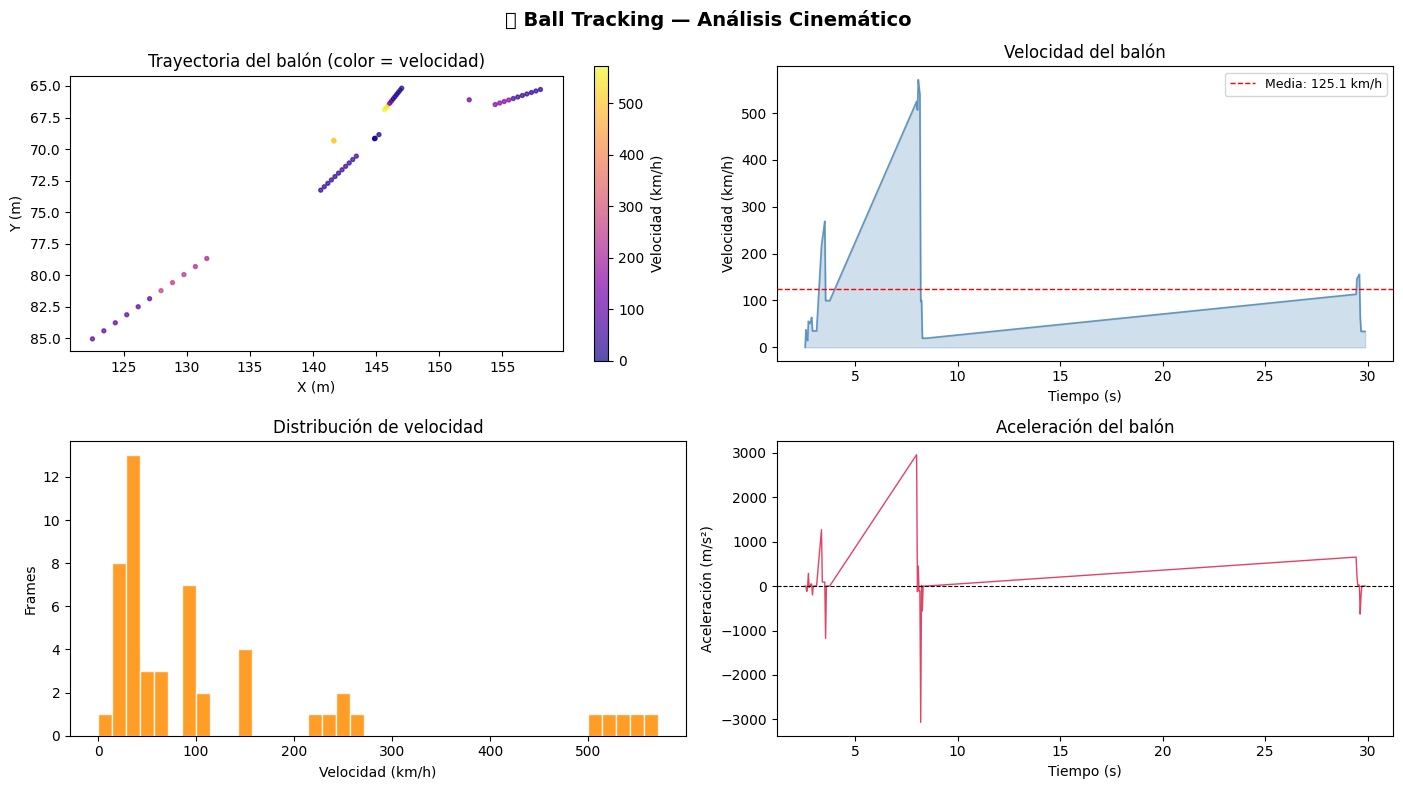

✅ Gráfico guardado en ball_analysis.png


In [12]:
if not ball_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle('⚽ Ball Tracking — Análisis Cinemático', fontsize=14, fontweight='bold')

    # ── Trayectoria en campo ───────────────────────────────────────────────
    ax = axes[0, 0]
    sc = ax.scatter(ball_df['mx'], ball_df['my'],
                    c=ball_df['speed_kmh'], cmap='plasma',
                    s=8, alpha=0.7)
    plt.colorbar(sc, ax=ax, label='Velocidad (km/h)')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Trayectoria del balón (color = velocidad)')
    ax.invert_yaxis()
    ax.set_aspect('equal')

    # ── Velocidad a lo largo del tiempo ───────────────────────────────────
    ax = axes[0, 1]
    ax.plot(ball_df['timestamp_s'], ball_df['speed_kmh'],
            color='steelblue', lw=1.2, alpha=0.8)
    ax.fill_between(ball_df['timestamp_s'], ball_df['speed_kmh'],
                    alpha=0.25, color='steelblue')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Velocidad (km/h)')
    ax.set_title('Velocidad del balón')
    ax.axhline(ball_df['speed_kmh'].mean(), color='red',
               linestyle='--', lw=1, label=f'Media: {ball_df["speed_kmh"].mean():.1f} km/h')
    ax.legend(fontsize=9)

    # ── Histograma de velocidad ────────────────────────────────────────────
    ax = axes[1, 0]
    ax.hist(ball_df['speed_kmh'], bins=40, color='darkorange', edgecolor='white', alpha=0.85)
    ax.set_xlabel('Velocidad (km/h)')
    ax.set_ylabel('Frames')
    ax.set_title('Distribución de velocidad')

    # ── Aceleración ───────────────────────────────────────────────────────
    ax = axes[1, 1]
    ax.plot(ball_df['timestamp_s'], ball_df['accel_ms2'],
            color='crimson', lw=1, alpha=0.8)
    ax.axhline(0, color='black', lw=0.8, linestyle='--')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Aceleración (m/s²)')
    ax.set_title('Aceleración del balón')

    plt.tight_layout()
    plt.savefig('ball_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✅ Gráfico guardado en ball_analysis.png')

## 13 · Si el balón no se detecta — modelo especializado

Si `yolov8n.pt` (COCO) sigue sin detectar el balón, usa un modelo entrenado específicamente
para fútbol. Las dos opciones más accesibles son:

### Opción A — Roboflow (sin GPU, gratis)
```python
# pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key='TU_API_KEY')   # regístrate gratis en roboflow.com
project = rf.workspace('roboflow-jvuqo').project('football-players-detection-3zvbc')
model_rf = project.version(1).model
# Luego en el bucle: result = model_rf.predict(frame_path, confidence=25, overlap=30).json()
```

### Opción B — YOLOv8 fine-tuned local
```bash
# Descarga el modelo pre-entrenado en balones de fútbol de Roboflow:
# https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc
# Luego:
MODEL_NAME = 'ruta/al/football_ball.pt'
BALL_CLASS_ID = 0   # ajusta según las clases del modelo descargado
```

### Opción C — Bajar umbral + ampliar tamaño máximo
```python
CONF_THRESHOLD = 0.10
MAX_BALL_SIZE  = 120
```